<a href="https://colab.research.google.com/github/ThierrryScotto/fer_recognition_using_frequency_neural_network/blob/master/basic_FreNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
import os
import glob
os.environ['LOG_LEVEL'] = 'INFO'
from src.datasets import ckextended
from src.image_processing import ImagePreProcessor
from src import utils
from src.variables import *
from scipy.fftpack import dct
from matplotlib import pyplot as plt

2024-08-05 14:47:19.935893: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 14:47:19.966591: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 14:47:20.008773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 14:47:20.055395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 14:47:20.077756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 14:47:20.170675: I tensorflow/core/platform/cpu_feature_gu

# Importing dataset

## Converting 1D vectors to images

In [2]:
images_labels = []

for index, row in ckextended.iterrows():
  image = utils.convert_str_to_array(row['pixels'])
  image = utils.convert_1D_array_to_image(image, HEIGHT, WIDTH)
  images_labels.append(row['emotion'])
  utils.write_image(image, f'{OUTPUT_PATH}_{index}.png')


In [3]:
ckextended

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training
...,...,...,...
915,5,87 86 88 92 92 127 231 248 251 253 254 254 254...,PrivateTest
916,5,21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...,PrivateTest
917,5,76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...,PrivateTest
918,5,114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...,PrivateTest


In [4]:
def get_emotion_by_index(df, idx):
    if idx in df.index:
        return df.loc[idx, 'emotion']
    else:
        return "Índice não encontrado"

#Image pre-processing

In [ ]:
import re

# Caminho para a pasta de entrada
input_folder = './content/images/input_images/'

# Pasta para salvar os rostos recortados
output_folder = './content/images/preprocessed_images'

image_pre_processor = ImagePreProcessor()
# Criar a pasta de saída, se não existir
os.makedirs(output_folder, exist_ok=True)

images_labels = []

# Processar cada imagem na pasta de entrada
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image_path = os.path.join(input_folder, filename)
        # print(f"nome da imagem {re.sub(r'\d+', '', image_path)}")
        numeros = re.findall(r'\d+', image_path)
        numero = [int(numero) for numero in numeros]
        images_labels.append(ckextended.loc[numero[0], 'emotion'])
        image_pre_processor.adjust_and_crop_face(image_path, output_folder)


In [7]:
# Caminhos das imagens
image_paths = glob.glob("./content/images/preprocessed_images/reconstructed_image_*")

# Lista para armazenar os arrays das imagens
image_arrays = []

# Carregar cada imagem e convertê-la em um array NumPy
for image_path in image_paths:
    if os.path.exists(image_path):
        image_array = utils.load_image(image_path)
        image_arrays.append(image_array)
    else:
        print(f"Imagem não encontrada: {image_path}")


In [8]:
γ = 0.25



In [9]:
frequency_input = []

for image in image_arrays:
    transformed_image = dct(dct(image.T, norm='ortho').T, norm='ortho')
    frequency_input.append(utils.resize_dct(transformed_image, γ))
    # frequency_input.append(dct(dct(image_arrays[index].T, norm='ortho').T, norm='ortho'))


In [10]:
print(len(frequency_input))
print(frequency_input[900].shape)

920
(8, 8)


**Paremeters**

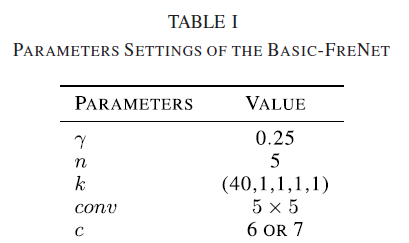

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Converter a lista de imagens em um numpy array e adicionar uma dimensão para o canal
frequency_input = np.array(frequency_input).reshape(-1, 8, 8, 1)

# Gerar labels fictícias para o exemplo
# Em um caso real, você deve ter suas labels reais
frequency_labels = np.random.randint(0, 7, size=(920, 1))
frequency_labels = tf.keras.utils.to_categorical(frequency_labels, 7)

# Determinar o batch size e número de epochs
batch_size = 128
epochs = 50

# Definir a arquitetura do modelo
input_images = tf.keras.Input(shape=(8, 8, 1), name='input_images')
flattened_images = layers.Flatten()(input_images)
fc1 = layers.Dense(2048, activation='relu', name='fc1')(flattened_images)
dropout1 = layers.Dropout(0.5)(fc1)
fc2 = layers.Dense(512, activation='relu', name='fc2')(dropout1)
dropout2 = layers.Dropout(0.5)(fc2)
output = layers.Dense(7, activation='softmax', name='output')(dropout2)

# Criar e compilar o modelo
model = models.Model(inputs=input_images, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sumário do modelo
model.summary()

# Treinar o modelo
model.fit(frequency_input, frequency_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Salvar o modelo treinado
model.save('basic_frenet_model.h5')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_images (InputLayer)       │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 2048)           │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185,799 (4.52 MB)

 Trainable params: 1,185,799 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1292 - loss: 513.8137 - val_accuracy: 0.1304 - val_loss: 100.2606
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1498 - loss: 191.2801 - val_accuracy: 0.1522 - val_loss: 30.8355
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1312 - loss: 78.3774 - val_accuracy: 0.1196 - val_loss: 6.5311
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1708 - loss: 23.4529 - val_accuracy: 0.1196 - val_loss: 1.9460
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1368 - loss: 5.8578 - val_accuracy: 0.1196 - val_loss: 1.9459
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1225 - loss: 2.9457 - val_accuracy: 0.1196 - val_loss: 1.9458
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1380 - loss: 2.5426 - val_accuracy: 0.1576 - val_loss: 1.9457
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1631 - loss: 2.1013 - val_accuracy: 0.1576 - val_loss

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Converter a lista de imagens em um numpy array e adicionar uma dimensão para o canal
frequency_input = np.array(frequency_input).reshape(-1, 8, 8, 1)

# Gerar labels fictícias para o exemplo
# Em um caso real, você deve ter suas labels reais
frequency_labels = np.random.randint(0, 7, size=(920, 1))
frequency_labels = tf.keras.utils.to_categorical(frequency_labels, 7)

# Determinar o batch size e número de epochs
batch_size = 128
epochs = 50

# Definir a arquitetura do modelo
input_images = tf.keras.Input(shape=(8, 8, 1), name='input_images')

# Multiplication layers
x = layers.Multiply()([input_images, input_images])  # Exemplo de camada de multiplicação

# Summarization layer
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten e camadas totalmente conectadas para classificação
flattened_images = layers.Flatten()(x)
fc1 = layers.Dense(2048, activation='relu', name='fc1')(flattened_images)
dropout1 = layers.Dropout(0.5)(fc1)
fc2 = layers.Dense(512, activation='relu', name='fc2')(dropout1)
dropout2 = layers.Dropout(0.5)(fc2)
output = layers.Dense(7, activation='softmax', name='output')(dropout2)

# Criar e compilar o modelo
model = models.Model(inputs=input_images, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sumário do modelo
model.summary()

# Treinar o modelo
model.fit(frequency_input, frequency_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Salvar o modelo treinado
model.save('frenet_model.h5')


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_images        │ (None, 8, 8, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 8, 8, 1)   │          0 │ input_images[0][… │
│ (Multiply)          │                   │            │ input_images[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 6, 32)  │        320 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 288)       │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 2048)      │    591,872 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc2 (Dense)         │ (None, 512)       │  1,049,088 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 512)       │          0 │ fc2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 7)         │      3,591 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,644,871 (6.27 MB)

 Trainable params: 1,644,871 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.1438 - loss: 746141.8750 - val_accuracy: 0.1957 - val_loss: 308453.6875
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1355 - loss: 323839.9375 - val_accuracy: 0.1467 - val_loss: 89359.9922
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1639 - loss: 115183.9766 - val_accuracy: 0.1413 - val_loss: 17763.0703
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1542 - loss: 46868.5938 - val_accuracy: 0.1304 - val_loss: 1157.8823
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1469 - loss: 13721.7178 - val_accuracy: 0.1413 - val_loss: 1.9458
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1479 - loss: 4588.9189 - val_accuracy: 0.1413 - val_loss: 1.9458
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1505 - loss: 1566.5071 - val_accuracy: 0.1413 - val_loss: 1.9459
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1414 - loss: 637.